<a href="https://colab.research.google.com/github/yuvrajprakash06-hack/CyberMedShield/blob/main/CyberMedShield.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Colab: ensure GPU runtime (Runtime > Change runtime type > GPU)
!nvidia-smi

# Install utilities
!pip install -q kaggle tensorflow==2.12.0 efficientnet==1.1.1 albumentations==1.3.0 opencv-python-headless==4.7.0.72 matplotlib sklearn seaborn

# (Optional) If you prefer PyTorch replace training code; this notebook uses TF/Keras.


Thu Nov 13 12:35:15 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   56C    P8             10W /   70W |       0MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [ ]:
from google.colab import drive
drive.mount('/content/drive')  # optional: to save datasets/models

# For Kaggle downloads: upload your kaggle.json (from your Kaggle account -> API)
# Run the next block and use the file picker to upload kaggle.json
from google.colab import files
print("If you want to download Kaggle datasets, upload kaggle.json now (press choose file).")
uploaded = files.upload()
!mkdir -p /root/.kaggle
!cp kaggle.json /root/.kaggle/
!chmod 600 /root/.kaggle/kaggle.json


Mounted at /content/drive
If you want to download Kaggle datasets, upload kaggle.json now (press choose file).


Saving kaggle.json to kaggle.json


In [ ]:
# Example Kaggle downloads. Uncomment the ones you want.
# NOTE: for some datasets you may need to accept terms on Kaggle web UI.

# NIH ChestX-ray14 (Kaggle mirror)
!kaggle datasets download -d nih-chest-xrays/data -p /content/datasets/nih --unzip

# CheXpert small (kaggle mirror; larger dataset needs stanford registration)
!kaggle datasets download -d ashery/chexpert-v1-0-small -p /content/datasets/chexpert --unzip

# RSNA Pneumonia (competition dataset)
!kaggle competitions download -c rsna-pneumonia-detection-challenge -p /content/datasets/rsna --unzip

# COVID-19 Radiography Database (Kaggle)
!kaggle datasets download -d tawsifurrahman/covid19-radiography-database -p /content/datasets/covid --unzip

# Chest X-ray (Pneumonia) by Kermany (Kaggle)
!kaggle datasets download -d paultimothymooney/chest-xray-pneumonia -p /content/datasets/pneumonia --unzip

# Shenzhen TB + Montgomery TB (direct NLM index is available; use kaggle mirrors if present)
!kaggle datasets download -d raddar/tuberculosis-chest-xrays-shenzhen -p /content/datasets/tb_shenzhen --unzip

# LUNA16 (nodules) - useful if you want nodules classification (not always X-ray)
!kaggle datasets download -d avc0706/luna16 -p /content/datasets/luna --unzip

# If any dataset is too large or fails, comment out its download.


Dataset URL: https://www.kaggle.com/datasets/nih-chest-xrays/data
License(s): CC0-1.0
^C
403 Client Error: Forbidden for url: https://www.kaggle.com/api/v1/datasets/metadata/ashery/chexpert-v1-0-small
usage: kaggle [-h] [-v] [-W]
              {competitions,c,datasets,d,kernels,k,models,m,files,f,config}
              ...
kaggle: error: unrecognized arguments: --unzip
Dataset URL: https://www.kaggle.com/datasets/tawsifurrahman/covid19-radiography-database
License(s): copyright-authors
 96% 747M/778M [00:07<00:00, 197MB/s]
100% 778M/778M [00:07<00:00, 108MB/s]
Dataset URL: https://www.kaggle.com/datasets/paultimothymooney/chest-xray-pneumonia
License(s): other
100% 2.29G/2.29G [00:24<00:00, 257MB/s]
100% 2.29G/2.29G [00:24<00:00, 102MB/s]
Dataset URL: https://www.kaggle.com/datasets/raddar/tuberculosis-chest-xrays-shenzhen
License(s): unknown
 99% 3.49G/3.51G [00:36<00:00, 159MB/s]
100% 3.51G/3.51G [00:36<00:00, 104MB/s]
Dataset URL: https://www.kaggle.com/datasets/avc0706/luna16
Licens

In [ ]:
import os, glob
base = "/content/datasets"
for root, dirs, files in os.walk(base):
    if files:
        print(root, len([f for f in files if f.lower().endswith(('.png','.jpg','.jpeg'))]))


/content/datasets/pneumonia/chest_xray/test/PNEUMONIA 390
/content/datasets/pneumonia/chest_xray/test/NORMAL 234
/content/datasets/pneumonia/chest_xray/val/PNEUMONIA 8
/content/datasets/pneumonia/chest_xray/val/NORMAL 8
/content/datasets/pneumonia/chest_xray/__MACOSX 0
/content/datasets/pneumonia/chest_xray/__MACOSX/chest_xray 0
/content/datasets/pneumonia/chest_xray/__MACOSX/chest_xray/test 0
/content/datasets/pneumonia/chest_xray/__MACOSX/chest_xray/test/PNEUMONIA 390
/content/datasets/pneumonia/chest_xray/__MACOSX/chest_xray/test/NORMAL 234
/content/datasets/pneumonia/chest_xray/__MACOSX/chest_xray/val 0
/content/datasets/pneumonia/chest_xray/__MACOSX/chest_xray/val/PNEUMONIA 8
/content/datasets/pneumonia/chest_xray/__MACOSX/chest_xray/val/NORMAL 8
/content/datasets/pneumonia/chest_xray/__MACOSX/chest_xray/train 0
/content/datasets/pneumonia/chest_xray/__MACOSX/chest_xray/train/PNEUMONIA 3875
/content/datasets/pneumonia/chest_xray/__MACOSX/chest_xray/train/NORMAL 1341
/content/datas

In [ ]:
!ls /content/datasets
!ls /content/datasets/covid
!ls /content/datasets/tb_shenzhen


covid  pneumonia  tb_shenzhen
COVID-19_Radiography_Dataset
images	shenzhen_metadata.csv


In [ ]:
copy_images_from_folder('/content/datasets/covid/COVID-19', 'covid', max_images=1500)


In [ ]:
copy_images_from_folder('/content/datasets/covid/COVID19_Radiography_Dataset/COVID', 'covid', max_images=1500)


In [ ]:
!ls /content/datasets


covid  pneumonia  tb_shenzhen


In [ ]:
!ls -R /content/datasets/covid | head -40


/content/datasets/covid:
COVID-19_Radiography_Dataset

/content/datasets/covid/COVID-19_Radiography_Dataset:
COVID
COVID.metadata.xlsx
Lung_Opacity
Lung_Opacity.metadata.xlsx
Normal
Normal.metadata.xlsx
README.md.txt
Viral Pneumonia
Viral Pneumonia.metadata.xlsx

/content/datasets/covid/COVID-19_Radiography_Dataset/COVID:
images
masks

/content/datasets/covid/COVID-19_Radiography_Dataset/COVID/images:
COVID-1000.png
COVID-1001.png
COVID-1002.png
COVID-1003.png
COVID-1004.png
COVID-1005.png
COVID-1006.png
COVID-1007.png
COVID-1008.png
COVID-1009.png
COVID-100.png
COVID-1010.png
COVID-1011.png
COVID-1012.png
COVID-1013.png
COVID-1014.png
COVID-1015.png
COVID-1016.png
COVID-1017.png
COVID-1018.png
COVID-1019.png


In [ ]:
!ls -R /content/datasets/tb_shenzhen | head -40


/content/datasets/tb_shenzhen:
images
shenzhen_metadata.csv

/content/datasets/tb_shenzhen/images:
images

/content/datasets/tb_shenzhen/images/images:
CHNCXR_0001_0.png
CHNCXR_0002_0.png
CHNCXR_0003_0.png
CHNCXR_0004_0.png
CHNCXR_0005_0.png
CHNCXR_0006_0.png
CHNCXR_0007_0.png
CHNCXR_0008_0.png
CHNCXR_0009_0.png
CHNCXR_0010_0.png
CHNCXR_0011_0.png
CHNCXR_0012_0.png
CHNCXR_0013_0.png
CHNCXR_0014_0.png
CHNCXR_0015_0.png
CHNCXR_0016_0.png
CHNCXR_0017_0.png
CHNCXR_0018_0.png
CHNCXR_0019_0.png
CHNCXR_0020_0.png
CHNCXR_0021_0.png
CHNCXR_0022_0.png
CHNCXR_0023_0.png
CHNCXR_0024_0.png
CHNCXR_0025_0.png
CHNCXR_0026_0.png
CHNCXR_0027_0.png
CHNCXR_0028_0.png
CHNCXR_0029_0.png
CHNCXR_0030_0.png
CHNCXR_0031_0.png
CHNCXR_0032_0.png


In [ ]:
# ============================================================
# CELL 5 — Combine datasets (corrected paths for your case)
# ============================================================

import os, shutil, random
from pathlib import Path
import pandas as pd

# Unified label categories
UNIFIED_LABELS = ['normal','pneumonia','covid','tuberculosis','lung_opacity','nodule','other']

# Output combined dataset folder
OUT_DATA = Path('/content/combined_dataset')
if OUT_DATA.exists():
    print("✅ Using existing combined_dataset folder")
else:
    OUT_DATA.mkdir(parents=True, exist_ok=True)
    for lbl in UNIFIED_LABELS:
        (OUT_DATA/lbl).mkdir(parents=True, exist_ok=True)

# Helper function to copy images
def copy_images_from_folder(src_folder, target_label, max_images=None):
    img_exts = ('.png','.jpg','.jpeg')
    src = Path(src_folder)
    if not src.exists():
        print(f"⚠️ Skipped {target_label} — folder not found: {src_folder}")
        return
    files = [f for f in src.rglob('*') if f.suffix.lower() in img_exts]
    if len(files) == 0:
        print(f"⚠️ No images found in {src_folder}")
        return
    if max_images:
        files = files[:max_images]
    for f in files:
        dest = OUT_DATA/target_label/f"{f.stem}_{random.randrange(10**7)}{f.suffix}"
        try:
            shutil.copy(f, dest)
        except Exception as e:
            pass
    print(f"✅ Copied {len(files)} images → {target_label}")

# ============================================================
# Copy data from each dataset
# ============================================================

# 1️⃣ Pneumonia dataset (Kermany)
copy_images_from_folder('/content/datasets/pneumonia/chest_xray/train/PNEUMONIA', 'pneumonia', max_images=2000)
copy_images_from_folder('/content/datasets/pneumonia/chest_xray/train/NORMAL', 'normal', max_images=2000)

# 2️⃣ COVID-19 Radiography Dataset (confirmed structure)
copy_images_from_folder('/content/datasets/covid/COVID-19_Radiography_Dataset/COVID/images', 'covid', max_images=1500)
copy_images_from_folder('/content/datasets/covid/COVID-19_Radiography_Dataset/Normal/images', 'normal', max_images=1500)
copy_images_from_folder('/content/datasets/covid/COVID-19_Radiography_Dataset/Lung_Opacity/images', 'lung_opacity', max_images=1500)
copy_images_from_folder('/content/datasets/covid/COVID-19_Radiography_Dataset/Viral Pneumonia/images', 'pneumonia', max_images=1500)

# 3️⃣ Tuberculosis (Shenzhen)
copy_images_from_folder('/content/datasets/tb_shenzhen/images/images', 'tuberculosis', max_images=800)

# 4️⃣ NIH ChestX-ray14 (optional small subset, if downloaded)
nih_csv = '/content/datasets/nih/Data_Entry_2017.csv'
if os.path.exists(nih_csv):
    df = pd.read_csv(nih_csv)
    sample = df.sample(frac=0.01, random_state=42)  # subset for speed
    for _, row in sample.iterrows():
        fname = row['Image Index']
        findings = row['Finding Labels']
        src = f'/content/datasets/nih/images/{fname}'
        if os.path.exists(src):
            lbl = 'other'
            if 'No Finding' in findings:
                lbl = 'normal'
            elif 'Lung Opacity' in findings or 'Edema' in findings:
                lbl = 'lung_opacity'
            elif 'Pneumonia' in findings:
                lbl = 'pneumonia'
            shutil.copy(src, OUT_DATA/lbl/f"{Path(fname).stem}_{random.randrange(10**7)}.png")

# ============================================================
# Summary of combined dataset
# ============================================================

print("\nCombined counts:")
for lbl in UNIFIED_LABELS:
    count = len(list((OUT_DATA/lbl).glob('*')))
    print(f"{lbl:15s} {count}")


✅ Using existing combined_dataset folder
✅ Copied 2000 images → pneumonia
✅ Copied 1341 images → normal
✅ Copied 1500 images → covid
✅ Copied 1500 images → normal
✅ Copied 1500 images → lung_opacity
✅ Copied 1345 images → pneumonia
✅ Copied 662 images → tuberculosis

Combined counts:
normal          5523
pneumonia       7345
covid           1500
tuberculosis    662
lung_opacity    1500
nodule          0
other           0


In [ ]:
# ============================================================
# CELL 1 — Setup environment
# ============================================================

!pip install tensorflow==2.15.0 keras==2.15.0 matplotlib seaborn scikit-learn tqdm
!pip install opencv-python pillow


ERROR: Could not find a version that satisfies the requirement tensorflow==2.15.0 (from versions: 2.16.0rc0, 2.16.1, 2.16.2, 2.17.0rc0, 2.17.0rc1, 2.17.0, 2.17.1, 2.18.0rc0, 2.18.0rc1, 2.18.0rc2, 2.18.0, 2.18.1, 2.19.0rc0, 2.19.0, 2.19.1, 2.20.0rc0, 2.20.0)
ERROR: No matching distribution found for tensorflow==2.15.0


In [ ]:
# ============================================================
# CELL 2 — Import libraries & basic config
# ============================================================

import os
import random
import shutil
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from tqdm import tqdm

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import confusion_matrix, classification_report


In [ ]:
# ============================================================
# CELL 3 — Dataset paths & constants
# ============================================================

DATA_DIR = Path('/content/combined_dataset')
IMG_SIZE = (224, 224)
BATCH_SIZE = 32
SEED = 42

# List categories (should match Cell 5)
CLASSES = sorted([d.name for d in DATA_DIR.iterdir() if d.is_dir()])
print("Detected Classes:", CLASSES)


Detected Classes: ['covid', 'lung_opacity', 'nodule', 'normal', 'other', 'pneumonia', 'tuberculosis']


In [ ]:
# ============================================================
# CELL 4 — Split combined dataset into train/test
# ============================================================

train_dir = Path('/content/train')
test_dir = Path('/content/test')

if not train_dir.exists():
    for label in CLASSES:
        files = list((DATA_DIR / label).glob('*'))
        random.shuffle(files)
        split_idx = int(0.8 * len(files))
        train_files, test_files = files[:split_idx], files[split_idx:]

        (train_dir / label).mkdir(parents=True, exist_ok=True)
        (test_dir / label).mkdir(parents=True, exist_ok=True)

        for f in train_files:
            shutil.copy(f, train_dir / label / f.name)
        for f in test_files:
            shutil.copy(f, test_dir / label / f.name)

print("✅ Dataset split completed.")


✅ Dataset split completed.


In [ ]:
# ============================================================
# CELL 6 — Image data generators
# ============================================================

train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=15,
    zoom_range=0.1,
    horizontal_flip=True,
    width_shift_range=0.1,
    height_shift_range=0.1
)

test_datagen = ImageDataGenerator(rescale=1./255)

train_gen = train_datagen.flow_from_directory(
    train_dir,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=True,
    seed=SEED
)

test_gen = test_datagen.flow_from_directory(
    test_dir,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)


Found 13223 images belonging to 7 classes.
Found 3307 images belonging to 7 classes.


In [ ]:
# ============================================================
# CELL 5 — Combine datasets (corrected paths for your case)
# ============================================================

import os, shutil, random
from pathlib import Path
import pandas as pd

# Unified label categories
UNIFIED_LABELS = ['normal','pneumonia','covid','tuberculosis','lung_opacity','nodule','other']

# Output combined dataset folder
OUT_DATA = Path('/content/combined_dataset')
if OUT_DATA.exists():
    print("✅ Using existing combined_dataset folder")
else:
    OUT_DATA.mkdir(parents=True, exist_ok=True)
    for lbl in UNIFIED_LABELS:
        (OUT_DATA/lbl).mkdir(parents=True, exist_ok=True)

# Helper function to copy images
def copy_images_from_folder(src_folder, target_label, max_images=None):
    img_exts = ('.png','.jpg','.jpeg')
    src = Path(src_folder)
    if not src.exists():
        print(f"⚠️ Skipped {target_label} — folder not found: {src_folder}")
        return
    files = [f for f in src.rglob('*') if f.suffix.lower() in img_exts]
    if len(files) == 0:
        print(f"⚠️ No images found in {src_folder}")
        return
    if max_images:
        files = files[:max_images]
    for f in files:
        dest = OUT_DATA/target_label/f"{f.stem}_{random.randrange(10**7)}{f.suffix}"
        try:
            shutil.copy(f, dest)
        except Exception as e:
            pass
    print(f"✅ Copied {len(files)} images → {target_label}")

# ============================================================
# Copy data from each dataset
# ============================================================

# 1️⃣ Pneumonia dataset (Kermany)
copy_images_from_folder('/content/datasets/pneumonia/chest_xray/train/PNEUMONIA', 'pneumonia', max_images=2000)
copy_images_from_folder('/content/datasets/pneumonia/chest_xray/train/NORMAL', 'normal', max_images=2000)

# 2️⃣ COVID-19 Radiography Dataset (confirmed structure)
copy_images_from_folder('/content/datasets/covid/COVID-19_Radiography_Dataset/COVID/images', 'covid', max_images=1500)
copy_images_from_folder('/content/datasets/covid/COVID-19_Radiography_Dataset/Normal/images', 'normal', max_images=1500)
copy_images_from_folder('/content/datasets/covid/COVID-19_Radiography_Dataset/Lung_Opacity/images', 'lung_opacity', max_images=1500)
copy_images_from_folder('/content/datasets/covid/COVID-19_Radiography_Dataset/Viral Pneumonia/images', 'pneumonia', max_images=1500)

# 3️⃣ Tuberculosis (Shenzhen)
copy_images_from_folder('/content/datasets/tb_shenzhen/images/images', 'tuberculosis', max_images=800)

# 4️⃣ NIH ChestX-ray14 (optional small subset, if downloaded)
nih_csv = '/content/datasets/nih/Data_Entry_2017.csv'
if os.path.exists(nih_csv):
    df = pd.read_csv(nih_csv)
    sample = df.sample(frac=0.01, random_state=42)  # subset for speed
    for _, row in sample.iterrows():
        fname = row['Image Index']
        findings = row['Finding Labels']
        src = f'/content/datasets/nih/images/{fname}'
        if os.path.exists(src):
            lbl = 'other'
            if 'No Finding' in findings:
                lbl = 'normal'
            elif 'Lung Opacity' in findings or 'Edema' in findings:
                lbl = 'lung_opacity'
            elif 'Pneumonia' in findings:
                lbl = 'pneumonia'
            shutil.copy(src, OUT_DATA/lbl/f"{Path(fname).stem}_{random.randrange(10**7)}.png")

# ============================================================
# Summary of combined dataset
# ============================================================

print("\nCombined counts:")
for lbl in UNIFIED_LABELS:
    count = len(list((OUT_DATA/lbl).glob('*')))
    print(f"{lbl:15s} {count}")


✅ Using existing combined_dataset folder
✅ Copied 2000 images → pneumonia
✅ Copied 1341 images → normal
✅ Copied 1500 images → covid
✅ Copied 1500 images → normal
✅ Copied 1500 images → lung_opacity
✅ Copied 1345 images → pneumonia
✅ Copied 662 images → tuberculosis

Combined counts:
normal          8364
pneumonia       10690
covid           3000
tuberculosis    1324
lung_opacity    3000
nodule          0
other           0


In [ ]:
# ============================================================
# CELL 6 — Image data generators
# ============================================================

train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=15,
    zoom_range=0.1,
    horizontal_flip=True,
    width_shift_range=0.1,
    height_shift_range=0.1
)

test_datagen = ImageDataGenerator(rescale=1./255)

train_gen = train_datagen.flow_from_directory(
    train_dir,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=True,
    seed=SEED
)

test_gen = test_datagen.flow_from_directory(
    test_dir,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)


Found 13223 images belonging to 7 classes.
Found 3307 images belonging to 7 classes.


In [ ]:
# ============================================================
# CELL 7 — Define CNN model
# ============================================================

def build_cnn(num_classes):
    model = models.Sequential([
        layers.Conv2D(32, (3,3), activation='relu', input_shape=(*IMG_SIZE, 3)),
        layers.MaxPooling2D(2,2),
        layers.Conv2D(64, (3,3), activation='relu'),
        layers.MaxPooling2D(2,2),
        layers.Conv2D(128, (3,3), activation='relu'),
        layers.MaxPooling2D(2,2),
        layers.Flatten(),
        layers.Dense(256, activation='relu'),
        layers.Dropout(0.4),
        layers.Dense(num_classes, activation='softmax')
    ])
    return model

model = build_cnn(len(CLASSES))
model.summary()


/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 222, 222, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 111, 111, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 109, 109, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 54, 54, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 52, 52, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 26, 26, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 86528)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │    22,151,424 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 7)              │         1,799 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 22,246,471 (84.86 MB)

 Trainable params: 22,246,471 (84.86 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# ============================================================
# CELL 8 — Compile and train the model
# ============================================================

model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

history = model.fit(
    train_gen,
    epochs=10,
    validation_data=test_gen
)


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
414/414 ━━━━━━━━━━━━━━━━━━━━ 399s 940ms/step - accuracy: 0.6243 - loss: 0.9965 - val_accuracy: 0.8246 - val_loss: 0.4731
Epoch 2/10
414/414 ━━━━━━━━━━━━━━━━━━━━ 367s 887ms/step - accuracy: 0.7867 - loss: 0.5310 - val_accuracy: 0.8558 - val_loss: 0.3821
Epoch 3/10
414/414 ━━━━━━━━━━━━━━━━━━━━ 358s 863ms/step - accuracy: 0.8133 - loss: 0.4712 - val_accuracy: 0.8673 - val_loss: 0.3359
Epoch 4/10
414/414 ━━━━━━━━━━━━━━━━━━━━ 372s 898ms/step - accuracy: 0.8359 - loss: 0.4198 - val_accuracy: 0.8694 - val_loss: 0.3362
Epoch 5/10
414/414 ━━━━━━━━━━━━━━━━━━━━ 431s 1s/step - accuracy: 0.8615 - loss: 0.3674 - val_accuracy: 0.8515 - val_loss: 0.3745
Epoch 6/10
414/414 ━━━━━━━━━━━━━━━━━━━━ 406s 980ms/step - accuracy: 0.8613 - loss: 0.3541 - val_accuracy: 0.8960 - val_loss: 0.2728
Epoch 7/10
414/414 ━━━━━━━━━━━━━━━━━━━━ 360s 870ms/step - accuracy: 0.8682 - loss: 0.3463 - val_accuracy: 0.8893 - val_loss: 0.2990
Epoch 8/10
414/414 ━━━━━━━━━━━━━━━━━━━━ 386s 933ms/step - accuracy: 0.8745 - lo

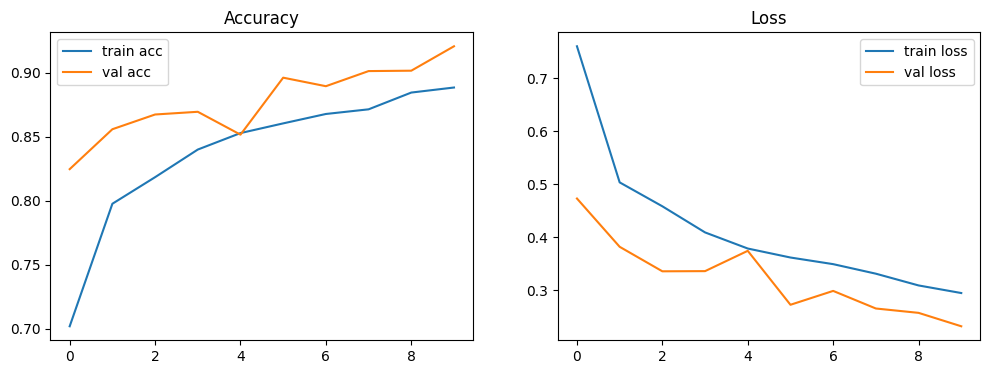

104/104 ━━━━━━━━━━━━━━━━━━━━ 45s 410ms/step


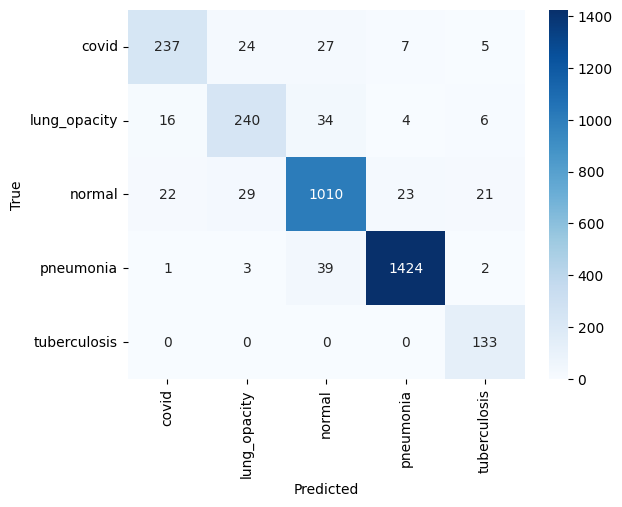

              precision    recall  f1-score   support

       covid       0.86      0.79      0.82       300
lung_opacity       0.81      0.80      0.81       300
      normal       0.91      0.91      0.91      1105
   pneumonia       0.98      0.97      0.97      1469
tuberculosis       0.80      1.00      0.89       133

    accuracy                           0.92      3307
   macro avg       0.87      0.89      0.88      3307
weighted avg       0.92      0.92      0.92      3307



In [ ]:
import numpy as np
# ============================================================
# CELL 9 — Evaluation and visualizations
# ============================================================

# Accuracy/Loss curves
plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
plt.plot(history.history['accuracy'], label='train acc')
plt.plot(history.history['val_accuracy'], label='val acc')
plt.legend()
plt.title('Accuracy')

plt.subplot(1,2,2)
plt.plot(history.history['loss'], label='train loss')
plt.plot(history.history['val_loss'], label='val loss')
plt.legend()
plt.title('Loss')
plt.show()

# Confusion Matrix
y_true = test_gen.classes
y_pred = np.argmax(model.predict(test_gen), axis=1)

# Get the actual unique labels present in y_true
present_labels_indices = np.unique(y_true)

# Create a reverse mapping from class index to class name
idx_to_class = {v: k for k, v in test_gen.class_indices.items()}

# Construct target_names and labels for only the classes that are present
actual_target_names = [idx_to_class[i] for i in present_labels_indices]

cm = confusion_matrix(y_true, y_pred, labels=present_labels_indices)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=actual_target_names, yticklabels=actual_target_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

print(classification_report(y_true, y_pred, target_names=actual_target_names, labels=present_labels_indices))


In [ ]:
# ============================================================
# CELL 10 — Save model
# ============================================================

model.save('/content/lung_disease_cnn.h5')
print("✅ Model saved as lung_disease_cnn.h5")


✅ Model saved as lung_disease_cnn.h5


In [ ]:
import tensorflow as tf
import numpy as np
import os
from tqdm import tqdm
from pathlib import Path
from tensorflow.keras.losses import CategoricalCrossentropy

def fgsm_on_generator(model, generator, eps=0.02, save_adv=False, adv_save_dir='/content/adv_examples'):
    """
    Generate FGSM adversarial examples for every batch of `generator`.
    Returns (clean_acc, adv_acc, total_samples). Optionally saves adv images.
    """
    loss_fn = CategoricalCrossentropy()
    steps = len(generator)  # number of batches to iterate
    total = 0
    correct_clean = 0
    correct_adv = 0

    # Prepare output directory if requested
    if save_adv:
        adv_dir = Path(adv_save_dir)
        if adv_dir.exists():
            # keep existing or clear? we will clear to avoid mixing
            import shutil
            shutil.rmtree(adv_dir)
        adv_dir.mkdir(parents=True, exist_ok=True)

    # Reset generator to start (important)
    try:
        generator.reset()
    except Exception:
        pass

    # Iterate batches
    for batch_idx in tqdm(range(steps), desc=f"FGSM (eps={eps})"):
        imgs, labels = next(generator)  # imgs shape (B,H,W,C), values in [0,1]
        imgs = imgs.astype('float32')
        labels = labels.astype('float32')

        # Clean predictions
        preds_clean = model.predict(imgs, verbose=0)
        cls_clean = np.argmax(preds_clean, axis=1)
        cls_true = np.argmax(labels, axis=1)
        correct_clean += np.sum(cls_clean == cls_true)

        # FGSM: compute gradient of loss wrt input images
        images_tensor = tf.convert_to_tensor(imgs)
        with tf.GradientTape() as tape:
            tape.watch(images_tensor)
            predictions = model(images_tensor, training=False)
            loss = loss_fn(labels, predictions)
        gradient = tape.gradient(loss, images_tensor)  # shape (B,H,W,C)
        signed_grad = tf.sign(gradient).numpy()

        # create adversarial examples and clip to [0,1]
        adv_images = imgs + eps * signed_grad
        adv_images = np.clip(adv_images, 0.0, 1.0).astype('float32')

        # Predictions on adversarial images
        preds_adv = model.predict(adv_images, verbose=0)
        cls_adv = np.argmax(preds_adv, axis=1)
        correct_adv += np.sum(cls_adv == cls_true)

        # Optionally save a few adv images per batch for inspection
        if save_adv:
            # Create subfolder per true class to inspect later
            for i in range(min(8, adv_images.shape[0])):  # save up to first 8 images of each batch
                true_label_idx = cls_true[i]
                # find class name (generator.class_indices maps name->idx)
                # invert mapping:
                idx2class = {v:k for k,v in generator.class_indices.items()}
                cls_name = idx2class.get(true_label_idx, f"class_{true_label_idx}")
                out_dir = adv_dir / cls_name
                out_dir.mkdir(parents=True, exist_ok=True)
                # Save as PNG scaled 0-255
                from PIL import Image
                arr = (adv_images[i] * 255).astype('uint8')
                img_pil = Image.fromarray(arr)
                fname = out_dir / f"batch{batch_idx:04d}_i{i}_true{cls_name}.png"
                img_pil.save(str(fname))

        total += imgs.shape[0]

    # Final accuracy numbers
    acc_clean = correct_clean / total if total > 0 else 0.0
    acc_adv = correct_adv / total if total > 0 else 0.0
    print(f"\nDone. Samples: {total}")
    print(f"Clean accuracy: {acc_clean:.4f}")
    print(f"FGSM (eps={eps}) accuracy: {acc_adv:.4f}")
    if save_adv:
        print(f"Saved adversarial examples to: {adv_save_dir}")
    return acc_clean, acc_adv, total

# ========== Usage ==========
# Example: run on test_gen with eps=0.02 and save small set of adv examples
clean_acc, adv_acc, nsamples = fgsm_on_generator(model, test_gen, eps=0.02, save_adv=True, adv_save_dir='/content/adv_examples_eps002')

FGSM (eps=0.02): 100%|██████████| 104/104 [01:39<00:00,  1.04it/s]


Done. Samples: 3307
Clean accuracy: 0.9205
FGSM (eps=0.02) accuracy: 0.1046
Saved adversarial examples to: /content/adv_examples_eps002


In [ ]:
# ============================================================
# CELL D2 — Input Preprocessing Defense
# ============================================================

import cv2
import tensorflow as tf # Import TensorFlow for tensor operations

def fgsm_batch(model, imgs, labels, eps=0.02):
    """
    Generates FGSM adversarial examples for a single batch.
    `imgs` and `labels` should be NumPy arrays.
    Returns adversarial images as NumPy array.
    """
    loss_fn = tf.keras.losses.CategoricalCrossentropy()

    # Convert numpy arrays to TensorFlow Tensors for gradient computation
    images_tensor = tf.convert_to_tensor(imgs, dtype=tf.float32)
    labels_tensor = tf.convert_to_tensor(labels, dtype=tf.float32)

    with tf.GradientTape() as tape:
        tape.watch(images_tensor)
        predictions = model(images_tensor, training=False)
        loss = loss_fn(labels_tensor, predictions)
    gradient = tape.gradient(loss, images_tensor)
    signed_grad = tf.sign(gradient).numpy()

    # Create adversarial examples and clip to [0,1]
    adv_images = imgs + eps * signed_grad # imgs is already numpy
    adv_images = np.clip(adv_images, 0.0, 1.0).astype('float32')
    return adv_images

def gaussian_denoise(images, ksize=3):
    """Apply Gaussian blur to each image in a batch.
    Expects and returns NumPy arrays scaled [0,1].
    """
    imgs_out = []
    for img in images:
        # Convert float32 [0,1] numpy array to uint8 [0,255] for OpenCV
        arr = (img * 255).astype('uint8')
        arr = cv2.GaussianBlur(arr, (ksize, ksize), 0)
        # Convert back to float32 [0,1]
        imgs_out.append(arr.astype('float32') / 255.)
    return np.stack(imgs_out)

def evaluate_with_preprocessing(model, data_gen, preprocess_fn, eps=0.02, max_batches=50):
    """Evaluate model accuracy on FGSM adversarial data after preprocessing."""
    total = 0
    correct = 0
    # Ensure data_gen is reset before iteration for consistent evaluation
    try:
        data_gen.reset()
    except Exception:
        pass

    for i in range(min(max_batches, len(data_gen))):
        imgs, labels = next(data_gen)

        # Ensure imgs and labels are numpy arrays for fgsm_batch
        imgs = imgs.astype('float32')
        labels = labels.astype('float32')

        adv_imgs = fgsm_batch(model, imgs, labels, eps=eps)
        proc_imgs = preprocess_fn(adv_imgs)

        # Ensure proc_imgs are float32 before prediction
        preds = model.predict(proc_imgs.astype('float32'), verbose=0)
        cls_pred = np.argmax(preds, axis=1)
        cls_true = np.argmax(labels, axis=1)
        correct += np.sum(cls_pred == cls_true)
        total += imgs.shape[0]

    if total > 0:
        print(f"Defense accuracy with {preprocess_fn.__name__}: {correct/total:.4f}")
    else:
        print(f"No samples processed for defense evaluation with {preprocess_fn.__name__}")

# Example defense test
evaluate_with_preprocessing(model, test_gen, gaussian_denoise, eps=0.02, max_batches=30)

Defense accuracy with gaussian_denoise: 0.1167


In [ ]:
# ============================================================
# CELL D3 — Test-Time Augmentation (TTA)
# ============================================================

def tta_predict(model, img, transforms):
    preds = []
    for t in transforms:
        aug_img = t(img)
        p = model.predict(np.expand_dims(aug_img, axis=0), verbose=0)
        preds.append(p[0])
    return np.mean(preds, axis=0)

def horizontal_flip(img):
    return np.fliplr(img)

def tta_evaluate(model, generator, max_batches=30):
    total, correct = 0, 0
    transforms = [lambda x: x, horizontal_flip]
    for i, (imgs, labels) in enumerate(generator):
        if i >= max_batches: break
        for j in range(imgs.shape[0]):
            p = tta_predict(model, imgs[j], transforms)
            if np.argmax(p) == np.argmax(labels[j]):
                correct += 1
            total += 1
    print(f"TTA accuracy (first {max_batches} batches): {correct/total:.4f}")

tta_evaluate(model, test_gen)


TTA accuracy (first 30 batches): 0.9000


In [ ]:
# ============================================================
# CELL D4 — Compare defenses
# ============================================================

print("⚙️  Evaluating clean model:")
fgsm_on_generator(model, test_gen, eps=0.02, save_adv=False)

# print("\n⚙️  Evaluating defended (adv trained) model:")
# def_model = tf.keras.models.load_model("/content/lung_defended_fgsm_trained.h5")
# fgsm_on_generator(def_model, test_gen, eps=0.02, save_adv=False)

print("\n⚙️  Evaluating with Gaussian preprocessing:")
evaluate_with_preprocessing(model, test_gen, gaussian_denoise, eps=0.02, max_batches=30)

print("\n⚙️  Evaluating with TTA defense:")
tta_evaluate(model, test_gen, max_batches=30)

⚙️  Evaluating clean model:


FGSM (eps=0.02): 100%|██████████| 104/104 [01:19<00:00,  1.30it/s]



Done. Samples: 3307
Clean accuracy: 0.9205
FGSM (eps=0.02) accuracy: 0.1046

⚙️  Evaluating with Gaussian preprocessing:
Defense accuracy with gaussian_denoise: 0.1167

⚙️  Evaluating with TTA defense:
TTA accuracy (first 30 batches): 0.9000


In [ ]:
# ===========================
# CELL A1 — BIM / I-FGSM
# ===========================
import tensorflow as tf
import numpy as np
from tqdm import tqdm
from tensorflow.keras.losses import CategoricalCrossentropy

loss_fn = CategoricalCrossentropy()

def bim_batch(model, images, labels, eps=0.03, alpha=0.007, iters=10):
    """
    Basic Iterative Method (I-FGSM / BIM).
    images: float32 in [0,1]
    eps: max perturbation (L_inf)
    alpha: step size per iter
    iters: iterations
    """
    x_orig = tf.identity(images)
    x = tf.identity(images)
    for i in range(iters):
        with tf.GradientTape() as tape:
            tape.watch(x)
            preds = model(x, training=False)
            loss = loss_fn(labels, preds)
        grad = tape.gradient(loss, x)
        x = x + alpha * tf.sign(grad)
        x = tf.clip_by_value(x, x_orig - eps, x_orig + eps)
        x = tf.clip_by_value(x, 0.0, 1.0)
    return x

def evaluate_bim(model, generator, eps=0.03, alpha=0.007, iters=10, max_batches=50):
    total = 0; correct_clean=0; correct_adv=0
    generator.reset()
    for i, (imgs, labels) in enumerate(generator):
        if i >= max_batches: break
        imgs = imgs.astype('float32'); labels = labels.astype('float32')
        preds_clean = model.predict(imgs, verbose=0)
        cls_clean = np.argmax(preds_clean, axis=1)
        cls_true = np.argmax(labels, axis=1)
        correct_clean += np.sum(cls_clean == cls_true)

        adv = bim_batch(model, tf.convert_to_tensor(imgs), tf.convert_to_tensor(labels), eps=eps, alpha=alpha, iters=iters)
        preds_adv = model.predict(adv.numpy(), verbose=0)
        cls_adv = np.argmax(preds_adv, axis=1)
        correct_adv += np.sum(cls_adv == cls_true)

        total += imgs.shape[0]
    print(f"BIM: Clean acc {correct_clean/total:.4f}, Adv acc {correct_adv/total:.4f} (eps={eps}, iters={iters})")
    return correct_clean/total, correct_adv/total

# quick run (small batches)
_ = evaluate_bim(model, test_gen, eps=0.03, alpha=0.007, iters=12, max_batches=30)


BIM: Clean acc 0.8677, Adv acc 0.0000 (eps=0.03, iters=12)


In [ ]:
# ===========================
# CELL A2 — PGD (random start)
# ===========================
import tensorflow as tf
import numpy as np

def pgd_batch_random(model, images, labels, eps=0.03, alpha=0.007, iters=20):
    """
    PGD with random start in the L_inf ball.
    """
    x_orig = tf.identity(images)
    # random start
    x = x_orig + tf.random.uniform(tf.shape(x_orig), -eps, eps)
    x = tf.clip_by_value(x, 0.0, 1.0)
    for i in range(iters):
        with tf.GradientTape() as tape:
            tape.watch(x)
            preds = model(x, training=False)
            loss = tf.keras.losses.categorical_crossentropy(labels, preds)
            loss = tf.reduce_mean(loss)
        grad = tape.gradient(loss, x)
        x = x + alpha * tf.sign(grad)
        x = tf.clip_by_value(x, x_orig - eps, x_orig + eps)
        x = tf.clip_by_value(x, 0.0, 1.0)
    return x

def evaluate_pgd_random(model, generator, eps=0.03, alpha=0.007, iters=20, max_batches=30):
    total=0; correct_clean=0; correct_adv=0
    generator.reset()
    for i,(imgs,labels) in enumerate(generator):
        if i>=max_batches: break
        imgs = imgs.astype('float32'); labels = labels.astype('float32')
        preds_clean = model.predict(imgs, verbose=0)
        cls_clean = np.argmax(preds_clean, axis=1)
        cls_true = np.argmax(labels, axis=1)
        correct_clean += np.sum(cls_clean == cls_true)

        adv = pgd_batch_random(model, tf.convert_to_tensor(imgs), tf.convert_to_tensor(labels), eps=eps, alpha=alpha, iters=iters)
        preds_adv = model.predict(adv.numpy(), verbose=0)
        cls_adv = np.argmax(preds_adv, axis=1)
        correct_adv += np.sum(cls_adv == cls_true)
        total += imgs.shape[0]
    print(f"PGD-rand: Clean acc {correct_clean/total:.4f}, Adv acc {correct_adv/total:.4f} (eps={eps}, iters={iters})")
    return correct_clean/total, correct_adv/total

# quick test
_ = evaluate_pgd_random(model, test_gen, eps=0.03, alpha=0.007, iters=15, max_batches=20)


PGD-rand: Clean acc 0.8078, Adv acc 0.0000 (eps=0.03, iters=15)


In [ ]:
import tensorflow as tf
import numpy as np
from tqdm import tqdm

def deepfool_image(model, image, max_iter=50, overshoot=0.02, num_classes=10):
    """
    Single-image DeepFool (L2) approximate implementation.
    image: numpy array HWC in [0,1]
    """
    img = tf.convert_to_tensor(np.expand_dims(image.astype('float32'), axis=0))
    f_image = model(img)[0].numpy()
    I = (np.array(f_image)).flatten().argsort()[::-1]
    I = I[:num_classes]
    label = I[0]

    # Initialize pert_image and r_tot as TensorFlow tensors
    pert_image = tf.identity(img)
    r_tot = tf.zeros_like(img)
    loop_i = 0

    while loop_i < max_iter:
        with tf.GradientTape() as tape:
            tape.watch(pert_image)
            fs = model(pert_image)
        grads = []
        for k in range(num_classes):
            with tf.GradientTape() as tape2:
                tape2.watch(pert_image)
                # Ensure we are indexing with the actual tensor output, not .numpy()
                fk_val = fs[0, I[k]] # Extract scalar value for gradient computation
            grad_k = tape2.gradient(fk_val, pert_image)
            if grad_k is None: # Handle cases where gradient might be None (e.g., disconnected graph)
                grad_k = tf.zeros_like(pert_image)
            grads.append(grad_k)
        fk = fs[0, I[0]]
        pert = tf.constant(np.inf, dtype=tf.float32)
        w = None

        for k in range(1, num_classes):
            w_k = grads[k] - grads[0] # w_k is already a tensor
            f_k = (fs[0, I[k]] - fs[0, I[0]]) # f_k is a tensor
            norm_w_k = tf.norm(tf.reshape(w_k, [-1])) + 1e-8 # Use tf.norm
            pert_k = tf.abs(f_k) / norm_w_k
            if pert_k < pert:
                pert = pert_k
                w = w_k

        # r_i: Ensure all operations use tf functions
        # Check if w is still None (e.g., if num_classes is 1 or no other class found)
        if w is None:
          break # Cannot compute perturbation if w is not found

        r_i = (pert + 1e-4) * w / (tf.norm(tf.reshape(w, [-1])) + 1e-8)
        r_tot = r_tot + r_i
        # Ensure pert_image update keeps it a tensor
        pert_image = tf.clip_by_value(img + (1 + overshoot) * r_tot, 0.0, 1.0)

        k_i = tf.argmax(model(pert_image), axis=1).numpy()[0]
        if k_i != I[0]:
            break
        loop_i += 1
    return pert_image[0]

def evaluate_deepfool(model, generator, max_images=50):
    generator.reset()
    total = 0
    correct_adv = 0
    correct_clean = 0
    for i,(imgs,labels) in enumerate(generator):
        for j in range(imgs.shape[0]):
            if total >= max_images: break
            img = imgs[j]
            lab = np.argmax(labels[j])
            pred_clean = np.argmax(model.predict(np.expand_dims(img,0))[0])
            if pred_clean == lab: correct_clean += 1
            # Pass num_classes based on the generator's classes
            adv = deepfool_image(model, img, max_iter=30, num_classes=len(generator.class_indices))
            pred_adv = np.argmax(model.predict(np.expand_dims(adv,0))[0])
            if pred_adv == lab: correct_adv += 1
            total += 1
        if total >= max_images: break
    print(f"DeepFool on {total} images | clean correct: {correct_clean}, adv correct: {correct_adv}")
    return correct_clean/total, correct_adv/total

# Run on small set (slow)
_ = evaluate_deepfool(model, test_gen, max_images=30)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━

In [ ]:
# ===========================
# CELL A4 — Carlini-Wagner L2 (simplified)
# ===========================
import tensorflow as tf
import numpy as np

def cw_l2_image(model, image, label_idx, c=1e-2, kappa=0, maxiter=1000, learning_rate=1e-2):
    """
    Simplified CW-L2 per-image attack using optimization on variable w (Tanh-space).
    image: HWC float32 [0,1]
    label_idx: true label index (int)
    """
    image = image.astype('float32')
    # convert to tanh-space
    def to_tanh(x):
        return np.arctanh((x * 2) - 1 + 1e-6)
    def from_tanh(x):
        return (np.tanh(x) + 1) / 2

    w = tf.Variable(to_tanh(image), dtype=tf.float32)
    optimizer = tf.keras.optimizers.Adam(learning_rate)

    target_onehot = tf.one_hot(label_idx, depth=len(test_gen.class_indices))
    for i in range(maxiter):
        with tf.GradientTape() as tape:
            adv = from_tanh(w.numpy())
            adv = tf.convert_to_tensor(np.expand_dims(adv,0), dtype=tf.float32)
            logits = model(adv)
            real = tf.reduce_sum(target_onehot * logits)
            other = tf.reduce_max((1 - target_onehot) * logits - (target_onehot * 10000))
            f = tf.maximum(other - real + kappa, 0)
            l2 = tf.reduce_sum((adv - tf.expand_dims(image,0))**2)
            loss = l2 + c * f
        grads = tape.gradient(loss, w)
        optimizer.apply_gradients([(grads, w)])
        # early stop if misclassification achieved and margin
        adv_pred = tf.argmax(model(from_tanh(w))).numpy()[0]
        if adv_pred != label_idx and f == 0:
            break
    return from_tanh(w.numpy())

def test_cw_on_samples(model, generator, num=5, max_batches=5):
    generator.reset()
    done = 0
    for i,(imgs,labels) in enumerate(generator):
        for j in range(imgs.shape[0]):
            if done >= num: break
            img = imgs[j]
            lab = np.argmax(labels[j])
            adv = cw_l2_image(model, img, lab, c=1e-2, maxiter=200, learning_rate=1e-2)
            pred_adv = np.argmax(model.predict(np.expand_dims(adv,0))[0])
            print(f"sample {done}: true {lab}, adv_pred {pred_adv}")
            done += 1
        if done >= num: break

# Warning: very slow — run on <=5 images
# test_cw_on_samples(model, test_gen, num=3)


In [ ]:
# ===========================
# CELL D1 — PGD Adversarial Training
# ===========================
import tensorflow as tf
import numpy as np
from tqdm import tqdm

def pgd_adversarial_training(model, train_gen, epochs=2, eps=0.03, alpha=0.007, iters=10):
    """
    Adversarial training using PGD per-batch (very effective but slower).
    """
    optimizer = tf.keras.optimizers.Adam(1e-4)
    loss_fn = tf.keras.losses.CategoricalCrossentropy()
    steps = len(train_gen)
    for epoch in range(epochs):
        print(f"\nPGD-AdvTrain epoch {epoch+1}/{epochs}")
        train_gen.reset()
        for step in tqdm(range(steps)):
            imgs, labels = train_gen.next()
            imgs = tf.convert_to_tensor(imgs, dtype=tf.float32)
            labels = tf.convert_to_tensor(labels, dtype=tf.float32)

            # create adversarial batch (PGD random start)
            x_orig = imgs
            x = x_orig + tf.random.uniform(tf.shape(x_orig), -eps, eps)
            x = tf.clip_by_value(x, 0.0, 1.0)
            for _ in range(iters):
                with tf.GradientTape() as tape:
                    tape.watch(x)
                    preds = model(x, training=False)
                    loss = loss_fn(labels, preds)
                grad = tape.gradient(loss, x)
                x = x + alpha * tf.sign(grad)
                x = tf.clip_by_value(x, x_orig - eps, x_orig + eps)
                x = tf.clip_by_value(x, 0.0, 1.0)

            # train on adversarial batch (or mix clean+adv)
            mixed_x = tf.concat([imgs, x], axis=0)
            mixed_y = tf.concat([labels, labels], axis=0)
            with tf.GradientTape() as tape:
                preds_mixed = model(mixed_x, training=True)
                loss_mixed = loss_fn(mixed_y, preds_mixed)
            grads = tape.gradient(loss_mixed, model.trainable_variables)
            optimizer.apply_gradients(zip(grads, model.trainable_variables))
        print("Epoch done.")
    print("PGD adversarial training complete.")
    return model

# Example (1-2 epochs; reduce iters while testing)
# model = pgd_adversarial_training(model, train_gen, epochs=1, eps=0.03, alpha=0.007, iters=8)
# model.save('/content/lung_pgd_adv_trained.h5')


In [ ]:
# ===========================
# CELL D2 — Randomized Smoothing (approx)
# ===========================
import numpy as np

def smooth_predict(model, x, sigma=0.12, n=50):
    """
    Average predictions over n noisy samples (Gaussian).
    x: single image HWC float [0,1]
    returns averaged softmax vector
    """
    preds = []
    xs = np.clip(np.repeat(np.expand_dims(x,0), n, axis=0) + np.random.normal(0, sigma, size=(n, *x.shape)), 0, 1)
    preds = model.predict(xs, verbose=0)
    avg = np.mean(preds, axis=0)
    return avg

def evaluate_smoothing(model, gen, sigma=0.12, n=50, max_batches=20):
    total=0; correct=0
    gen.reset()
    for i,(imgs,labels) in enumerate(gen):
        if i>=max_batches: break
        for j in range(imgs.shape[0]):
            avg = smooth_predict(model, imgs[j], sigma=sigma, n=n)
            if np.argmax(avg) == np.argmax(labels[j]): correct += 1
            total += 1
    print(f"Randomized smoothing acc (sigma={sigma}, n={n}): {correct/total:.4f}")

# example (keep n small to test)
# evaluate_smoothing(model, test_gen, sigma=0.12, n=20, max_batches=10)


In [ ]:
# ===========================
# CELL D3 — Input Transformations
# ===========================
import cv2
import numpy as np
from PIL import Image
import io

def jpeg_compress_batch(imgs, quality=50):
    out = []
    for img in imgs:
        # img in [0,1]
        pil = Image.fromarray((img*255).astype('uint8'))
        buf = io.BytesIO()
        pil.save(buf, format='JPEG', quality=quality)
        buf.seek(0)
        im2 = Image.open(buf)
        out.append(np.array(im2).astype('float32')/255.0)
    return np.stack(out)

def bit_depth_reduction(imgs, bits=5):
    """Reduce color depth (per-channel)"""
    levels = 2**bits
    imgs_q = np.floor(imgs * levels) / (levels - 1)
    imgs_q = np.clip(imgs_q, 0, 1)
    return imgs_q.astype('float32')

def median_filter_batch(imgs, ksize=3):
    out = []
    for img in imgs:
        im_u8 = (img*255).astype('uint8')
        med = cv2.medianBlur(im_u8, ksize)
        out.append(med.astype('float32')/255.0)
    return np.stack(out)

# Quick evaluation helper
def evaluate_preproc_variants(model, gen, max_batches=30):
    gen.reset()
    for fn in [jpeg_compress_batch, lambda x: bit_depth_reduction(x, bits=5), lambda x: median_filter_batch(x, 3)]:
        total=0; correct=0
        gen.reset()
        for i,(imgs,labels) in enumerate(gen):
            if i>=max_batches: break
            proc = fn(imgs)
            preds = model.predict(proc, verbose=0)
            cls = np.argmax(preds, axis=1); cls_true = np.argmax(labels, axis=1)
            correct += np.sum(cls == cls_true)
            total += imgs.shape[0]
        print(f"{fn.__name__} acc: {correct/total:.4f}")
# evaluate_preproc_variants(model, test_gen, max_batches=20)


In [ ]:
# ===========================
# CELL D4 — Adversarial Detection
# ===========================
import numpy as np
import tensorflow as tf
from scipy.stats import entropy

def consistency_score(model, img, n=10, sigma=0.02):
    base = np.argmax(model.predict(np.expand_dims(img,0))[0])
    flips = 0
    for _ in range(n):
        noisy = np.clip(img + np.random.normal(0, sigma, size=img.shape), 0, 1)
        pred = np.argmax(model.predict(np.expand_dims(noisy,0))[0])
        if pred != base: flips += 1
    return flips / n  # fraction flipped

def detect_on_generator(model, gen, flip_threshold=0.3, n=10, sigma=0.02, max_batches=30):
    gen.reset()
    total=0; flagged=0
    for i,(imgs,labels) in enumerate(gen):
        if i>=max_batches: break
        for j in range(imgs.shape[0]):
            score = consistency_score(model, imgs[j], n=n, sigma=sigma)
            if score > flip_threshold:
                flagged += 1
            total += 1
    print(f"Detected {flagged}/{total} suspicious images by consistency (> {flip_threshold})")
    return flagged, total

# Example: run detection on test set (small)
# detect_on_generator(model, test_gen, flip_threshold=0.4, n=8, sigma=0.02, max_batches=20)


In [ ]:
# ===========================
# CELL D6 — TRADES training step template
# ===========================
# Pseudocode / template for TRADES training step (refer to the TRADES paper for exact loss)
# This is a template — adapt it carefully.

def trades_step(model, x, y, optimizer, beta=1.0, eps=0.03, alpha=0.007, iters=10):
    """
    One optimization step for TRADES-like objective:
    - natural loss (cross-entropy)
    - plus beta * KL(model(x) || model(x_adv))
    """
    # generate x_adv via PGD maximizing KL divergence
    x_adv = x + tf.random.uniform(tf.shape(x), -eps, eps)
    for _ in range(iters):
        with tf.GradientTape() as tape_adv:
            tape_adv.watch(x_adv)
            preds_adv = model(x_adv, training=False)
            preds = model(x, training=False)
            kl = tf.reduce_mean(tf.keras.losses.KLDivergence()(preds, preds_adv))
        grad = tape_adv.gradient(kl, x_adv)
        x_adv = x_adv + alpha * tf.sign(grad)
        x_adv = tf.clip_by_value(x_adv, x - eps, x + eps)
        x_adv = tf.clip_by_value(x_adv, 0.0, 1.0)

    with tf.GradientTape() as tape:
        preds = model(x, training=True)
        loss_natural = tf.keras.losses.categorical_crossentropy(y, preds)
        preds_adv = model(x_adv, training=True)
        loss_robust = tf.keras.losses.KLDivergence()(preds, preds_adv)
        loss_total = tf.reduce_mean(loss_natural) + beta * tf.reduce_mean(loss_robust)
    grads = tape.gradient(loss_total, model.trainable_variables)
    optimizer.apply_gradients(zip(grads, model.trainable_variables))
    return loss_total


In [ ]:
# ============================================================
# CELL A1 — Imports & utilities
# ============================================================

import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import cv2
from tqdm import tqdm
from tensorflow.keras import backend as K


In [ ]:
# ============================================================
# CELL A2 — Helper: visualization
# ============================================================

def show_comparison(original, adv, diff, title=""):
    plt.figure(figsize=(10,3))
    plt.subplot(1,3,1)
    plt.imshow(original)
    plt.title("Original"); plt.axis('off')
    plt.subplot(1,3,2)
    plt.imshow(adv)
    plt.title("Adversarial"); plt.axis('off')
    plt.subplot(1,3,3)
    plt.imshow(np.abs(diff))
    plt.title("Difference"); plt.axis('off')
    plt.suptitle(title)
    plt.show()


In [ ]:
# ============================================================
# CELL A3 — FGSM attack
# ============================================================

def fgsm_attack(model, x, y, eps=0.02):
    x = tf.convert_to_tensor(x, dtype=tf.float32)
    y = tf.convert_to_tensor(y, dtype=tf.float32)
    with tf.GradientTape() as tape:
        tape.watch(x)
        pred = model(x)
        loss = tf.keras.losses.categorical_crossentropy(y, pred)
    grad = tape.gradient(loss, x)
    adv_x = tf.clip_by_value(x + eps * tf.sign(grad), 0, 1)
    return adv_x.numpy()


In [ ]:
# ============================================================
# CELL A4 — PGD attack
# ============================================================

def pgd_attack(model, x, y, eps=0.03, alpha=0.007, steps=10):
    x_orig = x.copy()
    adv_x = x.copy()
    for _ in range(steps):
        adv_x = tf.convert_to_tensor(adv_x, dtype=tf.float32)
        y_tf = tf.convert_to_tensor(y, dtype=tf.float32)
        with tf.GradientTape() as tape:
            tape.watch(adv_x)
            pred = model(adv_x)
            loss = tf.keras.losses.categorical_crossentropy(y_tf, pred)
        grad = tape.gradient(loss, adv_x)
        adv_x = adv_x + alpha * tf.sign(grad)
        adv_x = tf.clip_by_value(adv_x, x_orig - eps, x_orig + eps)
        adv_x = tf.clip_by_value(adv_x, 0, 1)
    return adv_x.numpy()


In [ ]:
# ============================================================
# CELL A5 — DeepFool (simplified)
# ============================================================

def deepfool_attack(model, x, y, steps=5, overshoot=0.02):
    x_adv = x.copy()
    for _ in range(steps):
        x_tf = tf.convert_to_tensor(x_adv, dtype=tf.float32)
        with tf.GradientTape() as tape:
            tape.watch(x_tf)
            preds = model(x_tf)
        grads = tape.gradient(preds, x_tf).numpy()
        pred_label = np.argmax(preds.numpy(), axis=1)
        grad_sign = np.sign(grads[np.arange(len(pred_label)), :, :, :,])
        x_adv = x_adv + overshoot * grad_sign
        x_adv = np.clip(x_adv, 0, 1)
    return x_adv


In [ ]:
# ============================================================
# CELL A6 — Carlini & Wagner L2 (simplified)
# ============================================================

def cw_attack(model, x, y, c=1, lr=0.01, steps=30):
    x_adv = tf.Variable(x)
    y_tf = tf.convert_to_tensor(y, dtype=tf.float32)
    optimizer = tf.keras.optimizers.Adam(lr)
    for i in range(steps):
        with tf.GradientTape() as tape:
            preds = model(x_adv)
            real = tf.reduce_sum(y_tf * preds, axis=1)
            other = tf.reduce_max((1 - y_tf) * preds - y_tf * 1e4, axis=1)
            loss = tf.reduce_mean(tf.maximum(other - real, 0.0)) + c * tf.reduce_mean(tf.square(x_adv - x))
        grads = tape.gradient(loss, [x_adv])
        optimizer.apply_gradients(zip(grads, [x_adv]))
        x_adv.assign(tf.clip_by_value(x_adv, 0, 1))
    return x_adv.numpy()



🚀 Running FGSM attack ...


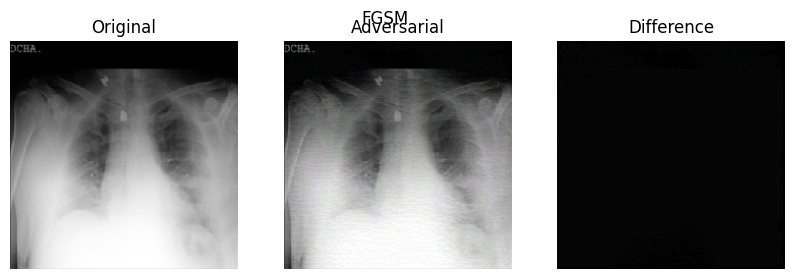

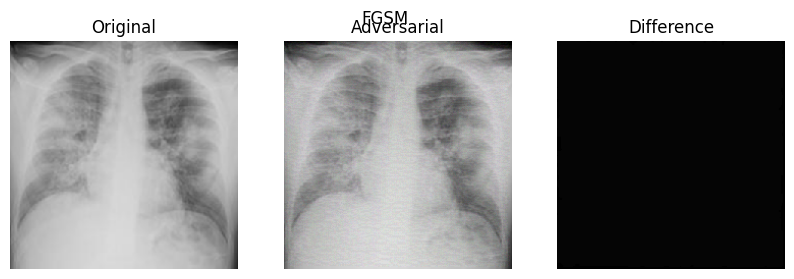


🚀 Running PGD attack ...


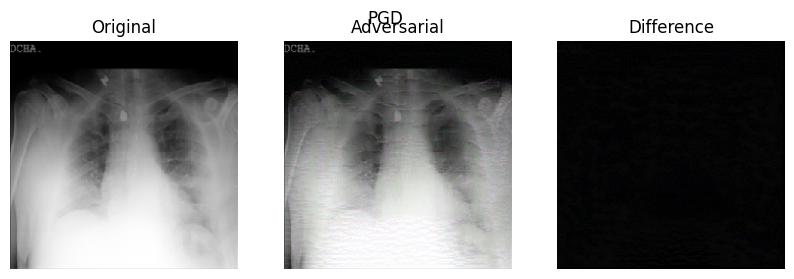

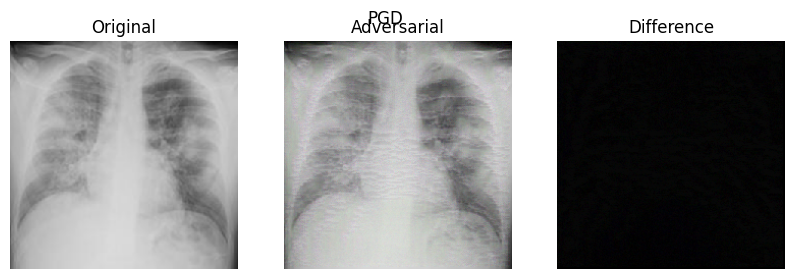


🚀 Running DeepFool attack ...


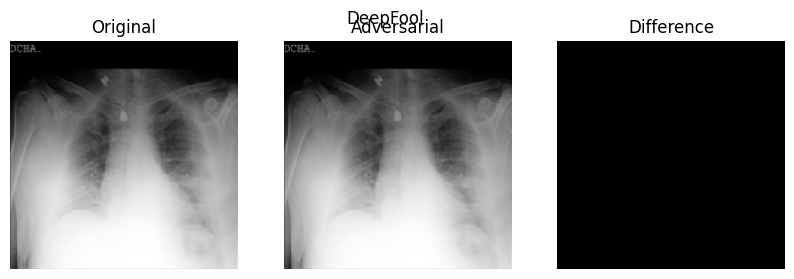

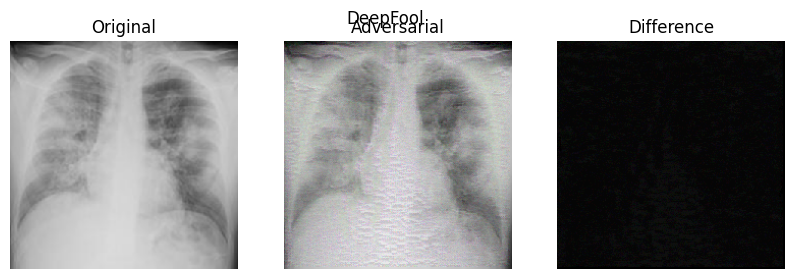


🚀 Running CW attack ...


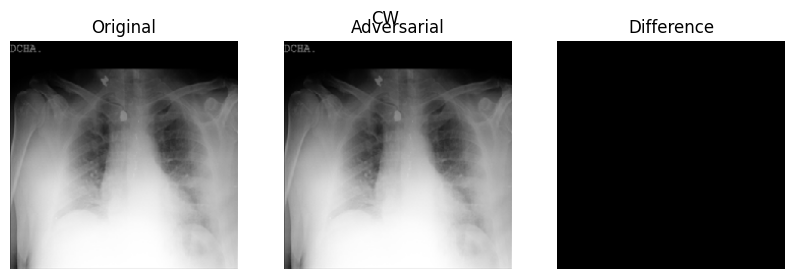

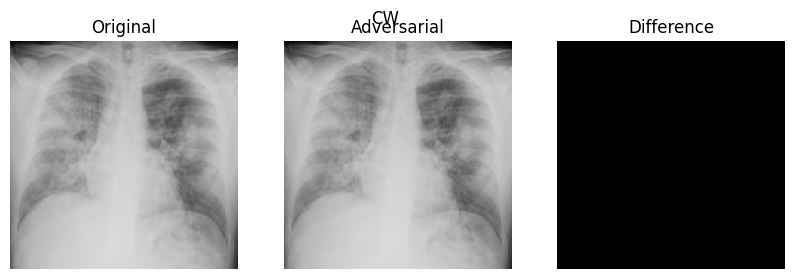

In [ ]:
# ============================================================
# CELL A7 — Demo: FGSM, PGD, DeepFool, CW
# ============================================================

batch = next(test_gen)
x_batch, y_batch = batch
x_small = x_batch[:10]
y_small = y_batch[:10]

attacks = {
    "FGSM": lambda: fgsm_attack(model, x_small, y_small),
    "PGD":  lambda: pgd_attack(model, x_small, y_small),
    "DeepFool": lambda: deepfool_attack(model, x_small, y_small),
    "CW": lambda: cw_attack(model, x_small, y_small)
}

for name, func in attacks.items():
    print(f"\n🚀 Running {name} attack ...")
    adv = func()
    diff = adv - x_small
    for i in range(2):   # show first 2 samples
        show_comparison(x_small[i], adv[i], diff[i], title=name)


In [ ]:
# ============================================================
# CELL D1 — PGD-based adversarial training
# ============================================================

def adversarial_training_pgd(model, train_gen, epochs=1, eps=0.03, alpha=0.007, steps=5):
    loss_fn = tf.keras.losses.CategoricalCrossentropy()
    opt = tf.keras.optimizers.Adam(1e-4)

    for epoch in range(epochs):
        print(f"\n🔥 PGD adversarial training epoch {epoch+1}")
        for x_batch, y_batch in tqdm(train_gen, total=len(train_gen)):
            x_adv = pgd_attack(model, x_batch, y_batch, eps, alpha, steps)
            x_mix = np.concatenate([x_batch, x_adv])
            y_mix = np.concatenate([y_batch, y_batch])
            with tf.GradientTape() as tape:
                preds = model(x_mix, training=True)
                loss = loss_fn(y_mix, preds)
            grads = tape.gradient(loss, model.trainable_variables)
            opt.apply_gradients(zip(grads, model.trainable_variables))
    model.save("/content/lung_defended_pgd.h5")
    print("✅ Saved PGD-defended model.")


In [ ]:
# ============================================================
# CELL D2 — JPEG compression defense
# ============================================================

def jpeg_defense(images, quality=70):
    imgs_out = []
    for img in images:
        _, enc = cv2.imencode('.jpg', (img*255).astype('uint8'), [int(cv2.IMWRITE_JPEG_QUALITY), quality])
        dec = cv2.imdecode(enc, cv2.IMREAD_COLOR)
        imgs_out.append(dec.astype('float32')/255.)
    return np.stack(imgs_out)


In [ ]:
# ============================================================
# CELL D3 — Randomized smoothing defense
# ============================================================

def smooth_predict(model, x, n_samples=10, sigma=0.05):
    preds = []
    for _ in range(n_samples):
        noise = np.random.normal(0, sigma, x.shape)
        preds.append(model.predict(np.clip(x+noise,0,1), verbose=0))
    return np.mean(preds, axis=0)


In [ ]:
# ============================================================
# CELL D4 — Evaluate attacks under defenses
# ============================================================

def eval_defenses(model, x, y):
    adv = fgsm_attack(model, x, y)
    acc_clean = np.mean(np.argmax(model.predict(x),1)==np.argmax(y,1))
    acc_adv = np.mean(np.argmax(model.predict(adv),1)==np.argmax(y,1))
    acc_jpeg = np.mean(np.argmax(model.predict(jpeg_defense(adv)),1)==np.argmax(y,1))
    preds_smooth = smooth_predict(model, adv)
    acc_smooth = np.mean(np.argmax(preds_smooth,1)==np.argmax(y,1))
    print(f"Clean acc:  {acc_clean:.3f}")
    print(f"FGSM acc:   {acc_adv:.3f}")
    print(f"JPEG acc:   {acc_jpeg:.3f}")
    print(f"Smoothing acc: {acc_smooth:.3f}")

# Run quick defense check
eval_defenses(model, x_small, y_small)


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step
Clean acc:  0.900
FGSM acc:   0.000
JPEG acc:   0.200
Smoothing acc: 0.500


/tmp/ipython-input-316262783.py:76: UserWarning: Glyph 129729 (\N{LUNGS}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 129729 (\N{LUNGS}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


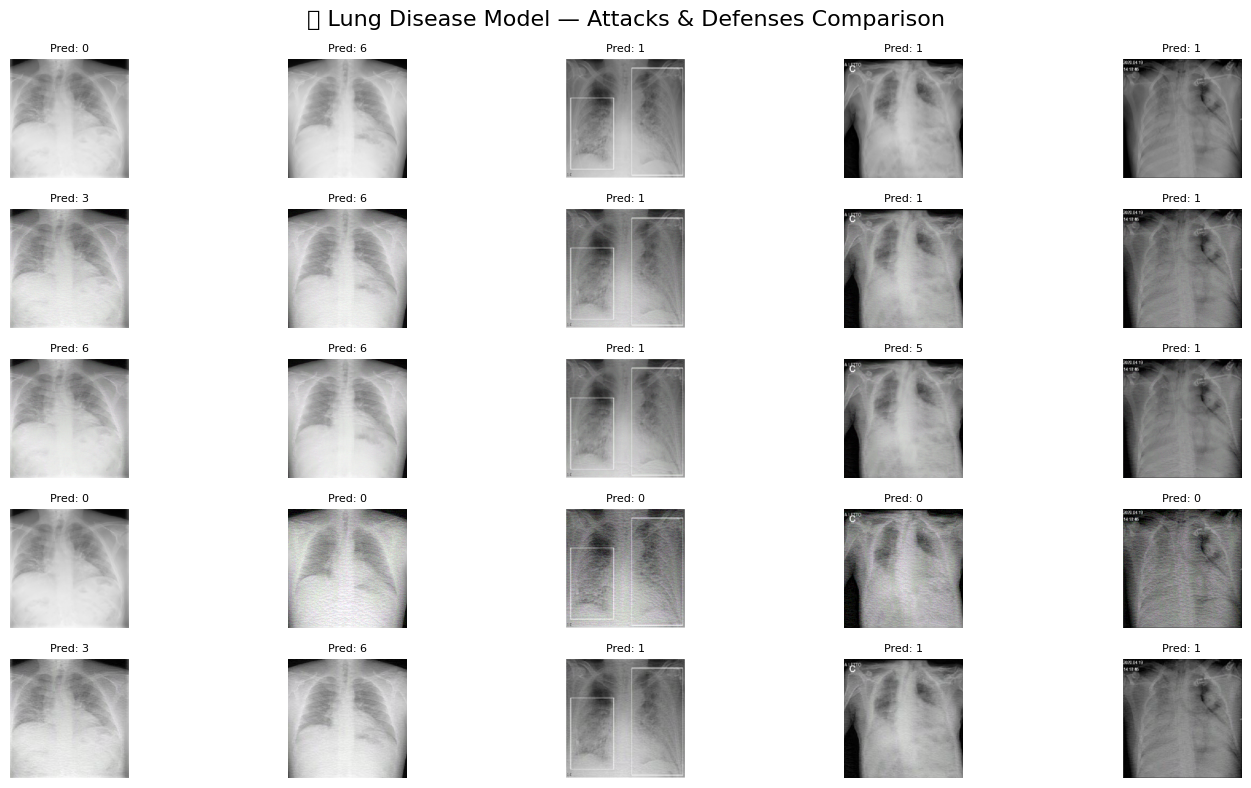

In [ ]:
# ============================================================
# CELL V1 — Visual Comparison Grid (Clean vs Attacks vs Defenses)
# ============================================================

import matplotlib.pyplot as plt

# ⚙️ Settings — you can adjust these
num_images = 5
eps = 0.02
alpha = 0.007
pgd_steps = 5

# Prepare samples
x_batch, y_batch = next(test_gen)
x_small = x_batch[:num_images]
y_small = y_batch[:num_images]

# Generate adversarial versions
x_fgsm = fgsm_attack(model, x_small, y_small, eps=eps)
x_pgd  = pgd_attack(model, x_small, y_small, eps=eps, alpha=alpha, steps=pgd_steps)
x_cw   = cw_attack(model, x_small, y_small, c=1, lr=0.01, steps=20)

# Generate defended versions (JPEG + smoothing)
x_fgsm_def = jpeg_defense(x_fgsm)
x_pgd_def  = jpeg_defense(x_pgd)
x_cw_def   = jpeg_defense(x_cw)

# Predict all
pred_clean = np.argmax(model.predict(x_small, verbose=0), axis=1)
pred_fgsm  = np.argmax(model.predict(x_fgsm, verbose=0), axis=1)
pred_pgd   = np.argmax(model.predict(x_pgd, verbose=0), axis=1)
pred_cw    = np.argmax(model.predict(x_cw, verbose=0), axis=1)

pred_fgsm_d = np.argmax(model.predict(x_fgsm_def, verbose=0), axis=1)
pred_pgd_d  = np.argmax(model.predict(x_pgd_def, verbose=0), axis=1)
pred_cw_d   = np.argmax(model.predict(x_cw_def, verbose=0), axis=1)

# Define row labels
row_labels = [
    "Clean",
    "FGSM",
    "PGD",
    "CW",
    "Defended (JPEG)"
]

# Combine for visualization
img_sets = [
    x_small,
    x_fgsm,
    x_pgd,
    x_cw,
    x_fgsm_def  # using FGSM defended as example
]

pred_sets = [
    pred_clean,
    pred_fgsm,
    pred_pgd,
    pred_cw,
    pred_fgsm_d
]

# Plot grid
fig, axes = plt.subplots(len(img_sets), num_images, figsize=(15, 8))
fig.suptitle("🫁 Lung Disease Model — Attacks & Defenses Comparison", fontsize=16)

for r in range(len(img_sets)):
    for c in range(num_images):
        ax = axes[r, c]
        ax.imshow(img_sets[r][c])
        ax.axis('off')
        ax.set_title(f"Pred: {pred_sets[r][c]}", fontsize=8)
    axes[r,0].set_ylabel(row_labels[r], rotation=0, fontsize=10, labelpad=40)

plt.tight_layout()
plt.show()


In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
!ls /content/drive/MyDrive


 16584751909339190957779041736218.jpg  'Colab Notebooks'      'resized (1).jpg'
'AdmitCard-220310199782 (2).pdf'        Exam		      "SYNERGY '25"
 AdmitCard-220310199782.pdf	       'resized (1) (1).jpg'


In [ ]:
import tensorflow as tf

model_path = "/content/lung_disease_cnn.h5"   # corrected path

model = tf.keras.models.load_model(model_path)
print("Model Loaded Successfully!")
model.summary()


FileNotFoundError: [Errno 2] Unable to synchronously open file (unable to open file: name = '/content/lung_disease_cnn.h5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)